# Fase 3 - SVM con embeddings ItWac 32 (in-genre classification)
Sviluppare un classificatore basato su SVM lineari che prende in input una rappresentazione del testo costruita attraverso l’uso dei word embedding (http://www.italianlp.it/resources/italian-word-embeddings/). Riportare i seguenti risultati:
- testare diverse rappresentazioni del testo che variano rispetto al modo di combinare gli embedding delle singole parole e/o rispetto alle categorie grammaticali delle paroleprese in considerazione. Valutare i diversi sistemi con un processo di 5-fold cross validation condotto sul training set;
- valutazione sul test set ufficiale del miglior sistema rispetto ai risultati ottenuti con il processo di 5-fold cross validation del punto sopra.

Dal task GxG Evalita 2018:

"Given a (collection of) text(s) from a specific genre, the gender of the author has to be predicted. The task is cast as a binary classification task, with gender represented as F (female) or M (male). Gender prediction will be done in two ways: 

1. **using a model which has been trained on the same genre**
2. using a model which has been trained on anything but that genre."

In questo file utilizzeremo un modello allenato sullo stesso genere su cui poi verrà testato.

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [2]:
def load_word_embeddings(src_path):
    embeddings = dict()
    with open(src_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip().split('\t')
            word = line[0]
            embedding = line[1:]
            embedding = [float(comp) for comp in embedding]
            embeddings[word] = np.asarray(embedding)
    return embeddings

## Definizione delle strategie di embedding

In [3]:
def load_conllu_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    tokens, pos_tags = [], []
    for line in lines:
        if line.startswith('#') or line.strip() == '':
            continue
        parts = line.strip().split('\t')
        if '-' in parts[0] or '.' in parts[0]:
            continue
        tokens.append(parts[1].lower())
        pos_tags.append(parts[3])
    return tokens, pos_tags

In [4]:
def get_label_from_filename(filename):
    return filename.split('#')[-1].split('.')[0]

In [5]:
def represent_text(tokens, model, pos_tags=None, 
                   allowed_pos=None, strategy='mean'):
    vectors = []
    for token, pos in zip(tokens, pos_tags):
        if allowed_pos and pos not in allowed_pos:
            continue
        if token in model:
            vectors.append(model[token])
    if not vectors:
        return np.zeros(next(iter(model.values())).shape[0])
    
    vectors = np.array(vectors)
    if strategy == 'mean':
        return np.mean(vectors, axis=0)
    elif strategy == 'sum':
        return np.sum(vectors, axis=0)
    elif strategy == 'max':
        return np.max(vectors, axis=0)
    else:
        raise ValueError(f"Unknown strategy: {strategy}")

In [6]:
dim = 32
embeddings_path = f'../../data/embeddings/itwac{dim}.txt'
embeddings = load_word_embeddings(embeddings_path)

## Estrazione delle feature e 5-Fold Cross Validation

In [7]:
strategies = [
    {'name': 'mean_all', 'strategy': 'mean', 'allowed_pos': None},
    {'name': 'mean_verb', 'strategy': 'mean', 'allowed_pos': ['VERB']},
    {'name': 'mean_noun_adj', 'strategy': 'mean', 'allowed_pos': ['NOUN', 'ADJ']},
    {'name': 'max_verb', 'strategy': 'max', 'allowed_pos': ['VERB']},
    {'name': 'max_all', 'strategy': 'max', 'allowed_pos': None},
    {'name': 'max_noun_adj', 'strategy': 'max', 'allowed_pos': ['NOUN', 'ADJ']}
]

genres = ['children']

In [8]:
results_cv = []
for genre in genres:
    print(f"\n=== GENRE: {genre} ===")
    train_folder = f"../../data/profiling_output/children/linguistic_annotation/children"
    test_folder = f"../../data/profiling_output/children/linguistic_annotation/children"

    for config in strategies:
        print(f"\n[STRATEGY: {config['name']}]")

        # Diagnostica: verifica file disponibili
        train_files = [f for f in os.listdir(train_folder) if f.startswith("training")]
        print(f"File trovati per il training ({len(train_files)}): {train_files[:5]}{' ...' if len(train_files) > 5 else ''}")

        X_train, y_train = [], []
        for filename in train_files:
            label = get_label_from_filename(filename)
            tokens, pos_tags = load_conllu_file(os.path.join(train_folder, filename))
            vector = represent_text(tokens, embeddings, pos_tags,
                                    allowed_pos=config['allowed_pos'],
                                    strategy=config['strategy'])
            X_train.append(vector)
            y_train.append(label)

        X_train = np.array(X_train)
        y_train = np.array(y_train)


        # Cross-validation
        # raccogli risultati per valutazione
        clf = LinearSVC()
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
        results_cv.append({
            'strategy': config['name'],
            'mean_accuracy': scores.mean(),
            'folds': scores.tolist()
        })
        
        scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
        print("CV Accuracy:", scores)
        print("Mean CV Accuracy:", scores.mean())

        # Test set
        X_test, ids = [], []
        for filename in os.listdir(test_folder):
            if not filename.startswith('test'):
                continue
            file_id = filename.split('#')[1]
            tokens, pos_tags = load_conllu_file(os.path.join(test_folder, filename))
            vector = represent_text(tokens, embeddings, pos_tags,
                                    allowed_pos=config['allowed_pos'],
                                    strategy=config['strategy'])
            X_test.append(vector)
            ids.append(file_id)
        X_test = np.array(X_test)

        # Train final model and predict
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        
        # Save CSV in sottocartella output/predizioni
        output = pd.DataFrame({'id': ids, 'gender': predictions})
        output_dir = "output_embeddings"
        os.makedirs(output_dir, exist_ok=True)
        output_file = os.path.join(output_dir, f'test_predictions_children_{config["name"]}.csv')

        output.to_csv(output_file, index=False)
        print(f"Predizioni salvate in: {output_file}")


=== GENRE: children ===

[STRATEGY: mean_all]
File trovati per il training (200): ['training#1#children#M.conllu', 'training#10#children#M.conllu', 'training#100#children#F.conllu', 'training#101#children#F.conllu', 'training#102#children#F.conllu'] ...
CV Accuracy: [0.45  0.6   0.45  0.575 0.625]
Mean CV Accuracy: 0.54
Predizioni salvate in: output_embeddings\test_predictions_children_mean_all.csv

[STRATEGY: mean_verb]
File trovati per il training (200): ['training#1#children#M.conllu', 'training#10#children#M.conllu', 'training#100#children#F.conllu', 'training#101#children#F.conllu', 'training#102#children#F.conllu'] ...
CV Accuracy: [0.3   0.5   0.475 0.6   0.7  ]
Mean CV Accuracy: 0.515
Predizioni salvate in: output_embeddings\test_predictions_children_mean_verb.csv

[STRATEGY: mean_noun_adj]
File trovati per il training (200): ['training#1#children#M.conllu', 'training#10#children#M.conllu', 'training#100#children#F.conllu', 'training#101#children#F.conllu', 'training#102#child

In [9]:
from tqdm.notebook import tqdm

results_cv = []
# Inizializzo tabella per i risultati
report_rows = []

for genre in genres:
    print(f"\n=== GENRE: {genre} ===")
    train_folder = f"../../data/profiling_output/{genre}/linguistic_annotation/{genre}/"
    test_folder = f"../../data/profiling_output/{genre}/linguistic_annotation/{genre}/"

    for config in tqdm(strategies, desc="Strategie"):
        print(f"\n[STRATEGY: {config['name']}]")

        # Caricamento dati di training
        train_files = [f for f in os.listdir(train_folder) if f.startswith("training")]
        X_train, y_train = [], []
        for filename in train_files:
            label = get_label_from_filename(filename)
            tokens, pos_tags = load_conllu_file(os.path.join(train_folder, filename))
            vector = represent_text(tokens, embeddings, pos_tags,
                                    allowed_pos=config['allowed_pos'],
                                    strategy=config['strategy'])
            X_train.append(vector)
            y_train.append(label)

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        clf = LinearSVC()
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')

        print("CV Accuracy:", scores)
        print("Mean CV Accuracy:", scores.mean())

        # Aggiunta al report
        report_rows.append({
            "genre": genre,
            "strategy": config["name"],
            "fold1": scores[0],
            "fold2": scores[1],
            "fold3": scores[2],
            "fold4": scores[3],
            "fold5": scores[4],
            "mean_accuracy": scores.mean()
        })


=== GENRE: children ===


Strategie:   0%|          | 0/6 [00:00<?, ?it/s]


[STRATEGY: mean_all]
CV Accuracy: [0.45  0.6   0.45  0.575 0.625]
Mean CV Accuracy: 0.54

[STRATEGY: mean_verb]
CV Accuracy: [0.3   0.5   0.475 0.6   0.7  ]
Mean CV Accuracy: 0.515

[STRATEGY: mean_noun_adj]
CV Accuracy: [0.6   0.625 0.725 0.55  0.55 ]
Mean CV Accuracy: 0.61

[STRATEGY: max_verb]
CV Accuracy: [0.325 0.6   0.575 0.625 0.55 ]
Mean CV Accuracy: 0.5349999999999999

[STRATEGY: max_all]
CV Accuracy: [0.6   0.6   0.725 0.675 0.5  ]
Mean CV Accuracy: 0.6199999999999999

[STRATEGY: max_noun_adj]
CV Accuracy: [0.575 0.65  0.575 0.6   0.525]
Mean CV Accuracy: 0.585


In [10]:
# Salvataggio CSV del report
output_dir = "output_embeddings"
os.makedirs(output_dir, exist_ok=True)

report_df = pd.DataFrame(report_rows)
report_path = os.path.join(output_dir, "report_valutazione_CH.csv")
report_df.to_csv(report_path, index=False)
print(f"\nReport salvato in {report_path}")


Report salvato in output_embeddings\report_valutazione_CH.csv



== Test set: strategia migliore = max_all ==

Accuracy totale sul test set: 0.5226

=== Classification Report ===
              precision    recall  f1-score   support

           F     0.5153    0.8400    0.6388       100
           M     0.5556    0.2020    0.2963        99

    accuracy                         0.5226       199
   macro avg     0.5354    0.5210    0.4675       199
weighted avg     0.5353    0.5226    0.4684       199

=== Confusion Matrix ===


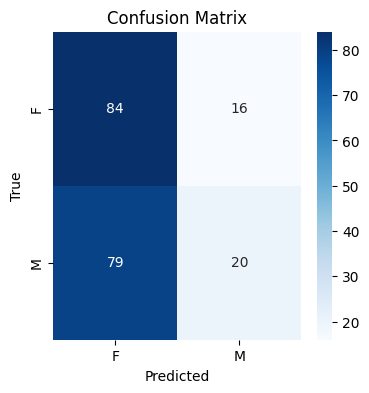

In [12]:
# === Ricostruzione di best_config a partire dai risultati CV ===
import pandas as pd

# report_rows è la lista raccolta durante la CV
df_cv = pd.DataFrame(report_rows)
best_row      = df_cv.loc[df_cv['mean_accuracy'].idxmax()]
best_strategy = best_row['strategy']
best_config   = next(cfg for cfg in strategies if cfg['name'] == best_strategy)

print(f"\n== Test set: strategia migliore = {best_strategy} ==\n")

# === Valutazione finale sul test set SOLO per la strategia migliore ===
from sklearn.metrics        import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Percorso alla cartella dei file test per children
test_folder = "../../data/profiling_output/children/linguistic_annotation/children/"

# Caricamento etichette gold
gold_path = "../../data/dataset_originale/gold/test_CH.gold"
gold_df   = pd.read_csv(gold_path, sep="\t", header=None, names=["id","gender"])
gold_dict = dict(zip(gold_df["id"].astype(str), gold_df["gender"]))

# Prepara X_test e ids usando la best_config
X_test, ids = [], []
for fn in os.listdir(test_folder):
    if not fn.startswith("test"):
        continue
    file_id = fn.split('#')[1]
    tokens, pos_tags = load_conllu_file(os.path.join(test_folder, fn))
    vector = represent_text(tokens, embeddings, pos_tags,
                            allowed_pos=best_config['allowed_pos'],
                            strategy=best_config['strategy'])
    X_test.append(vector)
    ids.append(file_id)

X_test = np.array(X_test)

# Allena il modello sull'intero training set (X_train, y_train) e predici
clf = LinearSVC(class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Allinea y_true
y_true = [gold_dict[i] for i in ids]

# Calcola e stampa le metriche
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy totale sul test set: {acc:.4f}\n")

print("=== Classification Report ===")
print(classification_report(y_true, y_pred, digits=4))

print("=== Confusion Matrix ===")
cm = confusion_matrix(y_true, y_pred, labels=["F","M"])
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["F","M"], yticklabels=["F","M"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Salvataggio CSV del report
df_test = pd.DataFrame(test_results)
df_test.to_csv("output_embeddings/risultati_test_set_CH.csv", index=False)
print("Report test salvato in: output_embeddings/risultati_test_set_CH.csv")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === CONFUSION MATRIX PER IL TEST SET (solo matplotlib) ===

genre_map = {
    "CH": "children",
    "DI": "diary",
    "JO": "journalism",
    "TW": "twitter"
}

inverse_map = {v: k for k, v in genre_map.items()}

for filename in os.listdir("output_embeddings"):
    if not filename.startswith("test_predictions_"):
        continue

    parts = filename.replace("test_predictions_", "").replace(".csv", "").split("_")
    genre = parts[0]
    strategy = "_".join(parts[1:])
    genre_abbr = inverse_map[genre]

    pred_df = pd.read_csv(os.path.join("output_embeddings", filename))

    gold_path = f"../../data/dataset_originale/gold/test_{genre_abbr}.gold"
    gold_df = pd.read_csv(gold_path, sep="\t", header=None, names=["id", "gender"])
    gold_dict = dict(zip(gold_df["id"].astype(str), gold_df["gender"]))

    print("Distribuzione etichette gold:", pd.Series(gold_labels).value_counts())

    
    pred_ids = pred_df["id"].astype(str)
    pred_labels = pred_df["gender"]
    gold_labels = [gold_dict.get(i, "UNK") for i in pred_ids]

    filtered = [(p, g) for p, g in zip(pred_labels, gold_labels) if g in {"M", "F"}]
    if not filtered:
        print(f"[{genre} - {strategy}] Nessuna etichetta valida trovata.")
        continue

    y_pred, y_true = zip(*filtered)
    cm = confusion_matrix(y_true, y_pred, labels=["M", "F"])

    print(f"\nConfusion Matrix - Genere: {genre} | Strategia: {strategy}")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["M", "F"])
    disp.plot(cmap="Blues")
    plt.title(f"{genre} - {strategy}")
    plt.grid(False)
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.dummy import DummyClassifier

# === VALUTAZIONE BASELINE CON DUMMY CLASSIFIER ===
dummy_results = []

for genre in genres:
    print(f"\n=== DUMMY CLASSIFIER - GENRE: {genre} ===")
    train_folder = f"../../data/profiling_output/children/linguistic_annotation/children/"
    test_folder = f"../../data/profiling_output/{genre}/linguistic_annotation/children"

    train_files = [f for f in os.listdir(train_folder) if f.startswith("training")]
    X_train, y_train = [], []
    for filename in train_files:
        label = get_label_from_filename(filename)
        tokens, pos_tags = load_conllu_file(os.path.join(train_folder, filename))
        vector = represent_text(tokens, embeddings, pos_tags, strategy='mean')  # usa 'mean' come default
        X_train.append(vector)
        y_train.append(label)

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)

    # Test set
    X_test, ids = [], []
    for filename in os.listdir(test_folder):
        if not filename.startswith("test"):
            continue
        file_id = filename.split('#')[1]
        tokens, pos_tags = load_conllu_file(os.path.join(test_folder, filename))
        vector = represent_text(tokens, embeddings, pos_tags, strategy='mean')
        X_test.append(vector)
        ids.append(file_id)

    X_test = np.array(X_test)
    predictions = dummy.predict(X_test)

    # Etichette gold
    genre_abbr = {"children": "CH", "diary": "DI", "journalism": "JO", "twitter": "TW"}[genre]
    gold_df = pd.read_csv(f"../../data/dataset_originale/gold/test_{genre_abbr}.gold", sep="\t", header=None, names=["id", "gender"])
    gold_dict = dict(zip(gold_df["id"].astype(str), gold_df["gender"]))

    gold_labels = [gold_dict.get(str(i), "UNK") for i in ids]
    filtered = [(p, g) for p, g in zip(predictions, gold_labels) if g in {"M", "F"}]

    if filtered:
        y_pred, y_true = zip(*filtered)
        acc = accuracy_score(y_true, y_pred)
    else:
        acc = 0.0

    dummy_results.append({
        "genre": genre,
        "strategy": "dummy_most_frequent",
        "test_accuracy": acc
    })

# Salva il report dummy
df_dummy = pd.DataFrame(dummy_results)
df_dummy.to_csv("output_embeddings/risultati_test_set_CH_dummy.csv", index=False)
print("Dummy classifier: report salvato in output_embeddings/risultati_test_set_CH_dummy.csv")

## Selezione della strategia migliore

In [ ]:
# === Selezione della strategia migliore ===
import pandas as pd

df_cv = pd.DataFrame(report_rows)
best_row = df_cv.loc[df_cv['mean_accuracy'].idxmax()]
best_strategy = best_row['strategy']
print("Strategia migliore:", best_strategy)

best_config = [cfg for cfg in strategies if cfg['name'] == best_strategy][0]

## Valutazione sul test set

In [ ]:
# === Valutazione sul test set solo per la strategia migliore ===
print(f"\n== Valutazione sul test set per la strategia migliore: {best_config['name']} ==")

test_folder = "../../data/profiling_output/children/linguistic_annotation/children/"
X_test, ids = [], []
for filename in os.listdir(test_folder):
    if not filename.startswith('test'):
        continue
    file_id = filename.split('#')[1]
    tokens, pos_tags = load_conllu_file(os.path.join(test_folder, filename))
    vector = represent_text(tokens, embeddings, pos_tags,
                            allowed_pos=best_config['allowed_pos'],
                            strategy=best_config['strategy'])
    X_test.append(vector)
    ids.append(file_id)

X_test = np.array(X_test)

# Usa lo stesso modello addestrato sull'intero training set (X_train, y_train)
clf = LinearSVC()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print("Distribuzione predizioni:", pd.Series(predictions).value_counts())


# Mostra predizioni
output = pd.DataFrame({'id': ids, 'gender': predictions})
print("Prime predizioni:")
display(output.head())
print("Distribuzione predizioni:", output['gender'].value_counts().to_dict())



# === Confusion Matrix e Classification Report ===
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Etichette gold
genre_abbr = {"children": "CH"}[genre]
gold_df = pd.read_csv(f"../../data/dataset_originale/gold/test_{genre_abbr}.gold", sep="\t", header=None, names=["id", "gender"])
gold_dict = dict(zip(gold_df["id"].astype(str), gold_df["gender"]))

gold_labels = [gold_dict.get(str(i), "UNK") for i in ids]
filtered = [(p, g) for p, g in zip(predictions, gold_labels) if g in {"M", "F"}]

if filtered:
    y_pred, y_true = zip(*filtered)

    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, digits=4))
    acc = accuracy_score(y_true, y_pred)
    print(f"\n=== Accuracy totale sul test set: {acc:.4f}")


    print("\n=== Confusion Matrix ===")
    cm = confusion_matrix(y_true, y_pred, labels=["F", "M"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["F", "M"], yticklabels=["F", "M"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
else:
    print("Nessun esempio valido per il calcolo della confusion matrix.")